<h2> Reduced Basis Methods for the Helmholz Equation </h2>

We want to create a reduced basis space for the Helmholz equation
\begin{equation}
    \Delta u - \omega^2u = f
\end{equation}

and Robin ("absorbing") boundary conditions

$$
\frac{\partial u}{\partial n} + i \omega u = 0 \qquad \text{ on } \partial \Omega
$$

defined on a two dimensional domain $\Omega$. It has the Galerkin formulation in the finite element space $V_h$. Find an $u_h$ so that

\begin{equation}
    \int_{\Omega} \nabla u_h \nabla v_h \text{dx} - i\omega \int_{\partial \Omega} u_hv_h \text{ds} - \omega^2 \int_{\Omega} u_hv_h \text{dx}  = \int_{\Omega} fv_h \text{dx}
\end{equation}

holds for all $v_h \in V_h$. We can write this as an equation of bilinearforms 

\begin{equation}
    k(u_h, v_h) + \omega r(u_h,v_h) + \omega^2 m(u_h, v_h) = \int_{\Omega} fv_h \text{dx}  \tag{1}
\end{equation}

where $r$ only exists if we want Robin boundary conditions, otherwise $r(u,v) \equiv 0$. To get Dirichlet boundaries, we choose our test functions $v$ from the Sobolev space $H_0^1(\Omega)$ and Neumann boundaries are enforced for $v \in H^1(\Omega)$. 

<h3> The reduced basis method </h3>

In a nutshell the idea of creating a reduced basis space is to choose a so called snapshot of $N$ parameters $ \{ \omega_1, .., \omega_N \} $ for which we solve the system $(1)$. By doing so we get linearly independent snapshot solutions $\{u_h^1, .., u_h^N\}$. The space 
\begin{equation}
V_N := \overline{\text{span}\{u_h^1, .., u_h^N\}}
\end{equation}
is a linear subspace of $V_h$. To approximate a solution for an arbitrary $\omega$ we now have to solve the system $(1)$ only for $v_N \in V_N$, which is computationally way less expensive than solving the original system. 

<h3> Generate a Reduced Basis Space </h3>

We first need to import some libraries and then we write a little python class. 

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from ngsolve import *
from netgen.geom2d import unit_square


import numpy as np
import scipy
import math
import time

from ngsolve.webgui import Draw

np.random.seed(42)



The input parameter for the class is the finite element space, a list `blf` containing the bilinear forms in order `[k, r, m]` where `None` indicates that a bilinear form is constant zero and a right hand side `rhs`. The parameter `snap` is a list with inital snapshot parameters.

In [2]:
class ReducedBasis:
    
    def __init__(self, fes, blf, rhs, snap = None):

        self.logging = True    
        
        self.fes = fes
        
        # set (bi-)linear forms and matrices
        self.omega = Parameter(0)

        self.bfs = {} # dictionary for bilinear forms
        self.a = BilinearForm(self.fes)
        for j in range(3):
            if blf[j]:
                self.a += sum([self.omega**j*igl.coef * igl.symbol for igl in blf[j]])
                self.bfs[j] = BilinearForm(blf[j]).Assemble()
        self.a.Assemble()
        
        self.f = LinearForm(self.fes)
        self.f += rhs
        self.f.Assemble()
                
        # store ainv for better performance
        self.ainv = self.a.mat.Inverse(self.fes.FreeDofs(), inverse="sparsecholesky")

        # initialize grid functions
        self.gfu = GridFunction(self.fes)
        self.drawu = GridFunction(self.fes)

        # temporary ngsolve vectors
        self.__bv_tmp = self.bfs[[*self.bfs][0]].mat.CreateColVector()
        self.__bv_tmp2 = self.bfs[[*self.bfs][0]].mat.CreateColVector()
        self.__gf_tmp = GridFunction(self.fes)
        
        
        self.proj = Projector(self.fes.FreeDofs(), True)

        # compute norm of f
        self.__bv_tmp.data = self.proj*self.f.vec
        self.f.vec.data = self.__bv_tmp.data
        self.__normf = Norm(self.__bv_tmp)**2
        
        self.__snapshots = []
        self.V = None

        if snap is not None:
            self.addSnapshots(snap)
            

Next we can create a function that takes a list of omegas, sets them as snapshots and computes the reduced basis. To have the possibility to dynamically expand our reduced basis later on, we will expand the list of snapshot parameters instead of resetting them.

Let $n$ be the dimension of the original space $V_h$. The snapshot solutions $\{u_h^1, .., u_h^N\}$ could be used directly as basis functions for $V_N$. However we prefer the matrix $V \in \mathbb{R}^{n\times N} $ that contains the coefficients of the reduced basis functions $\{\zeta^1, .., \zeta^N\}$  to be as pretty as possible. Therefore we make sure that the coefficient vectors of the $\zeta_i$ form an ortonormal system respective the Euklidean norm. This we achieve by performing a QR-decomposition and only using the Q part. 


We now solve the equation $(1)$ in the original space for the new snapshots. If the matrix $V$ already contains some basis functions, we extend the basis. 

In [3]:
class ReducedBasis(ReducedBasis):

    def addSnapshots(self, new_snapshots):
        
        if self.logging: print("compute Reduced Basis for snapshots ", new_snapshots)
    
        with TaskManager():
            
            for omega in new_snapshots:
                if omega not in self.__snapshots:
                    
                    self.__snapshots.append(omega)

                    # compute FEM solution for parameter omega
                    self.omega.Set(omega)
                    self.a.Assemble()

                    self.ainv.Update()
                    self.gfu.vec.data = self.ainv * self.f.vec

                    if self.V is None:
                        self.V = MultiVector(self.gfu.vec, 1)
                        self.V[0] = self.gfu.vec
                    else:
                        self.V.AppendOrthogonalize(self.gfu.vec)
                        
            # compute matrices in reduced space
            mv = MultiVector(self.gfu.vec, len(self.__snapshots))
            self.red = {} # dictionary of matrices in reduced space
            for key in self.bfs.keys():
                mv[0:len(self.__snapshots)] = self.bfs[key].mat * self.V
                self.red[key] = InnerProduct(self.V, mv)

            # right hand side in reduced space
            mv = MultiVector(self.f.vec, 1)
            mv[0] = self.f.vec
            self.f_red = InnerProduct(self.V, mv)
            
            
            if self.logging: print("finished computing Reduced Basis")
                
        # store smallest and biggest snapshot parameter
        self.omega_min = min(self.__snapshots)
        self.omega_max = max(self.__snapshots)
        
        
        # only needed in this Jupyter Notebook 
        self.__update_res_mat = True


    def getSnapshots(self):
        return self.__snapshots

To look at the solutions of the reduced system, we want to implement a draw function, that takes a parameter $\omega$, computes the reduced solution and displays it in the ngsolve webgui.

In [4]:

class ReducedBasis(ReducedBasis):
    
    def draw(self, omega, redraw=False):
        
        # compute reduced solution

        ## TODO: updatable a_red.inv (Base Matrix instead of bla-Matrix?) and omega as parameter
        A = Matrix(len(self.__snapshots), len(self.__snapshots), self.fes.is_complex)
        A[:] = 0
        for key in self.red.keys():
            A += self.red[key]*omega**key
        
        v = A.I * self.f_red
        
        self.drawu.vec.data = self.V * v[:,0]
        
        if self.logging: print("omega: {}, norm of solution: {}".format(omega, 
            np.real(Integrate ( Conj(self.drawu)*(self.drawu), self.fes.mesh))))
        
        # draw solution
        if not redraw:
            self.scene = Draw(self.drawu)
        else:
            self.scene.Redraw()


To test the implementation so far, we define an H1-FEM space on the unit square with Dirichlet boundary values on the bottom and right. To compute the first set of snapshot solutions we choose the parameters $\omega \in \{0, .., 10\}$. Subsequently we create a slider to visualize the reduced solutions for a set of omegas. 

In [5]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.2))
fes = H1(mesh, order=3 ,dirichlet="bottom|right")
u,v = fes.TnT()
rhs = 100*exp(-20*((x-0.6)**2 + (y-0.3)**2))*v*dx
# blf = ['grad(u)*grad(v)*dx', None, '-u*v *dx']
blf = [grad(u)*grad(v)*dx, None, -u*v *dx]
snapshots = np.arange(1,11, 1)

space = ReducedBasis(fes, blf, rhs, snapshots)

slider_func = lambda x: space.draw(x, redraw=True)
space.draw(space.omega_min)

interact(slider_func, x=widgets.FloatSlider(min=space.omega_min, max=space.omega_max, step=0.05, value=space.omega_min))

compute Reduced Basis for snapshots  [ 1  2  3  4  5  6  7  8  9 10]
finished computing Reduced Basis
omega: 1, norm of solution: 4.751257782884026


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2007-9-ga349a5c89', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, …

interactive(children=(FloatSlider(value=1.0, description='x', max=10.0, min=1.0, step=0.05), Output()), _dom_c…

<function __main__.<lambda>(x)>

<h3> Compute the residual </h3>

Let $M, K, R \in \mathbb{C}^{nxn}$ and $F \in \mathbb{C}^{n}$ be the matrices (respectively the vector) be defined as

\begin{equation}
\begin{split}
    M_{j,k} &= \int_{\Omega} \nabla \zeta_j \nabla \zeta_k \text{dx} ~, \\
    K_{j,k} &= -\int_{\Omega} \zeta_j \zeta_k \text{dx} ~, \\
    R_{j,k} &= -i\int_{\partial \Omega} \zeta_j \zeta_k \text{ds} ~ ,\\
    F_j &= \int_{\Omega} f \zeta_j \text{dx} ~.
\end{split}
\end{equation}

 A solution of the reduced system can be written as $Vu = \sum_{j = 1}^{N}u_j\zeta_j \in V_h$ with coefficient vector $u = (u_1, .., u_N)$. Therefore a norm of the residual can be defined as $|| (K+\omega^2 M +\omega R)Vu -F||$.


By squaring and rearranging the therm above we get an expression for the residual

\begin{equation}
\begin{split}
    \text{res}(\omega) :&= || (K+\omega^2 M +\omega R)Vu -F||_2^2 \\
    &= || (K+\omega^2 M +\omega R)Vu||_2^2 - 2\text{Re} \langle (K+\omega^2 M +\omega R)Vu , F \rangle + ||F||_2^2 \\
    &= \sum_{j = 1}^N \sum_{k = 1}^N u_j \overline{u_k}\langle (K+\omega^2 M +\omega R)\zeta_j, (K+\omega^2 M +\omega R)\zeta_k \rangle - 2\text{Re}\sum_{j = 1}^N u_j \langle (K+\omega^2 M +\omega R)\zeta_j, F \rangle  + || F||^2 \\
    & = \overline{u^T}Au - 2\text{Re} A_F u + || F||^2
\end{split} 
\end{equation}
where 
\begin{equation}
\begin{split}
    (A)_{jk} = ~ & \langle K\zeta_j, K\zeta_k \rangle + \omega \left(\langle R\zeta_j, K\zeta_k \rangle + \langle K\zeta_j, R\zeta_k \rangle \right)\\
    &+ \omega^2 \left(\langle M\zeta_j, K\zeta_k \rangle + \langle K\zeta_j, M\zeta_k \rangle + \langle R\zeta_j, R\zeta_k \rangle \right) \\
       & + \omega^3 \left(\langle R\zeta_j, M\zeta_k \rangle + \langle M\zeta_j, R\zeta_k \rangle\right)+ \omega^4 \langle M\zeta_j, M\zeta_k \rangle .
\end{split}
\end{equation}
and 
\begin{equation}
    (A_F)_{j} = \langle K\zeta_j, F \rangle + \omega^2 \langle M\zeta_j, F \rangle +\omega \langle R\zeta_j, F \rangle.
\end{equation}

Now we can implement a function that build all the necessary matrices. 

We now want to plot the norms and residuals of the solutions for a large set of different omegas. Therefore we extend our class by a function that takes a vector of omegas and returns the corresponding values (norm and/or residual).

In [6]:
class ReducedBasis(ReducedBasis):

    def __computeResMat(self):

        self.__update_res_mat = False
        dim = (self.red[[*self.red][0]].h, self.red[[*self.red][0]].w)
        tmp = MultiVector(self.__bv_tmp, dim[0])
        
        names = ['k', 'r', 'm']
        keys = []
        zeta = {}
        with TaskManager():
            for i in self.bfs.keys():
                # set multivectors
                zeta[names[i]] = MultiVector(self.__bv_tmp, dim[0])
                tmp.data = self.bfs[i].mat * self.V
                zeta[names[i]].data = self.proj * tmp
                # set keys
                for k in range(i, 3):
                    if k in self.bfs.keys(): keys += [names[i]+names[k]]
            
            self.__res_mat = {} # available keys: 'kk', 'kr', 'km', 'rr', 'rm', 'mm'

            # calculate scalar products
            for key in keys:
                self.__res_mat[key] = InnerProduct (zeta[key[0]], zeta[key[1]])
                # calculate inner products with right hand side
                if key[0] == key[1]:
                    self.__res_mat['{}f'.format(key[0])] = Vector(dim[0], self.fes.is_complex)
                    for j in range(dim[0]): 
                        self.__res_mat['{}f'.format(list(key)[0])][j] = InnerProduct (zeta[key[0]][j], self.f.vec.data)

            # set other matrices to zero
            for key in ['kk', 'kr', 'km', 'rr', 'rm', 'mm']:
                if key not in keys:
                    self.__res_mat[key] = Matrix(dim[0], dim[1], self.fes.is_complex)
                    self.__res_mat[key][:] = 0

            for i in range(3):
                if i not in self.bfs.keys():
                    self.__res_mat['{}f'.format(names[i])] = Vector(dim[0], self.fes.is_complex)
                    self.__res_mat['{}f'.format(names[i])][:] = 0


In [7]:
class ReducedBasis(ReducedBasis):
    
    def computeValues(self, param, residual=True, norm=True, cheap = True):
        
        if residual and norm: 
            if self.logging: print("compute residual and norm")
        elif residual: 
            if self.logging: print("compute residual")
        elif norm: 
            if self.logging: print("compute norm")
        else: return
        
        norm_ret = []
        residual_ret = []
        # needed only in this jupyter notebook
        if self.__update_res_mat:
            self.__computeResMat()
        self.__update_res_mat = False

        
        with TaskManager():

            for omega in param:
                
                # compute reduced solution
                ## TODO: updatable a_red.inv (Base Matrix instead of bla-Matrix?) and omega as parameter
                A = Matrix(len(self.__snapshots), len(self.__snapshots), self.fes.is_complex)
                A[:] = 0
                for key in self.red.keys():
                    A += self.red[key]*omega**key
                v = A.I * self.f_red
                red_sol_vec = v[:,0]
            
                if norm:

                    self.__gf_tmp.vec.data = self.V * red_sol_vec
                    # imaginary part is not exactly 0 due to numerical errors
                    nof = np.real(Integrate(self.__gf_tmp*Conj(self.__gf_tmp), self.fes.mesh))
                    norm_ret += [nof]

                if residual:   
                    
                    if cheap:
                        
                        if self.__update_res_mat:
                            self.__computeResMat()
                            
                            
                        A_F = self.__res_mat['kf']+self.__res_mat['mf']*omega**2+self.__res_mat['rf'] *omega
                        
                        if self.fes.is_complex:
                            A = (self.__res_mat['kk']
                                 + (self.__res_mat['kr']+self.__res_mat['kr'].H)*omega 
                                 + (self.__res_mat['km']+self.__res_mat['km'].H+self.__res_mat['rr'])*omega**2
                                 + (self.__res_mat['rm']+self.__res_mat['rm'].H)*omega**3
                                 + self.__res_mat['mm']*omega**4)
                            
                            
                        else:
                            A = (self.__res_mat['kk']
                                 + self.__res_mat['km']*2*omega**2
                                 + self.__res_mat['mm']*omega**4 
                                 + self.__res_mat['kr']*2*omega
                                 + self.__res_mat['rm']*2*omega**3)
                            
                        res = (InnerProduct(red_sol_vec, A * red_sol_vec) 
                               - 2*np.real( InnerProduct(red_sol_vec, A_F, conjugate = False)) 
                               + self.__normf)
                        
                        residual_ret += [abs(res)]

                    else:
                        
                        if not norm: self.__gf_tmp.vec.data = self.V * red_sol_vec
                        self.omega.Set(omega)
                        self.a.Assemble()
                        self.__bv_tmp.data = self.a.mat*self.__gf_tmp.vec - self.f.vec
                        self.__bv_tmp2.data = self.proj*self.__bv_tmp
                        res = Norm(self.__bv_tmp2)**2
                    
                        residual_ret += [res]
                    
                    
        if self.logging: print("finished computing values")
        if norm and (not residual): return norm_ret
        if residual and (not norm): return residual_ret
        if norm and residual: return norm_ret, residual_ret
    

Again we define an instance of our now updated class. Afterwards we can plot norm and residuals for a set of random omegas. 

In [8]:
space1= ReducedBasis(fes, [grad(u)*grad(v)*dx, None, -u*v *dx], rhs, snapshots)

random_omegas = np.sort(np.append(np.random.uniform(space.omega_min, space.omega_max, 1000), snapshots))
norm_random_omegas, residual_random_omegas = space1.computeValues(random_omegas, cheap= True)

compute Reduced Basis for snapshots  [ 1  2  3  4  5  6  7  8  9 10]
finished computing Reduced Basis
compute residual and norm
finished computing values


<IPython.core.display.Javascript object>


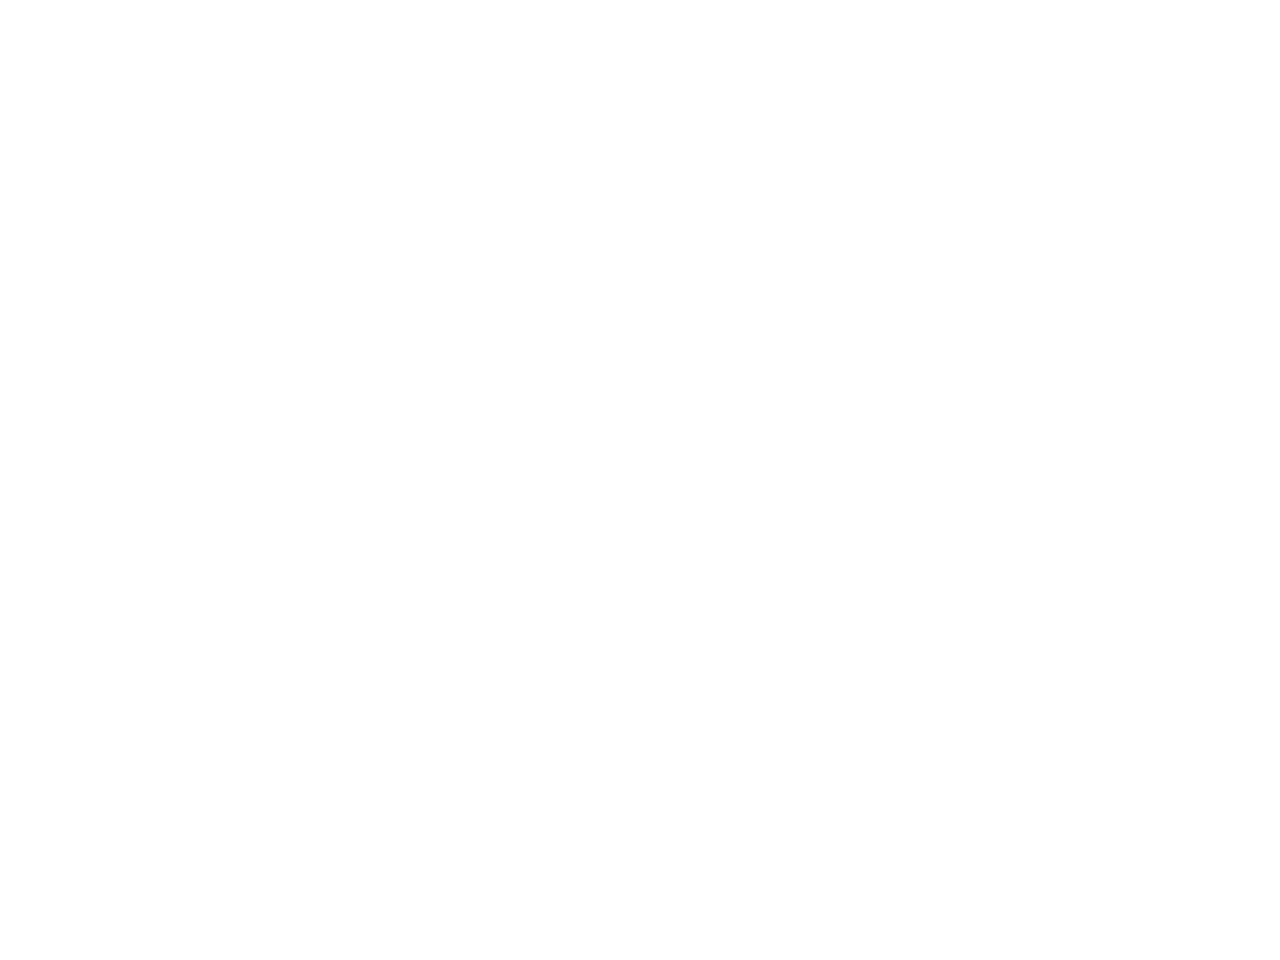

<IPython.core.display.Javascript object>


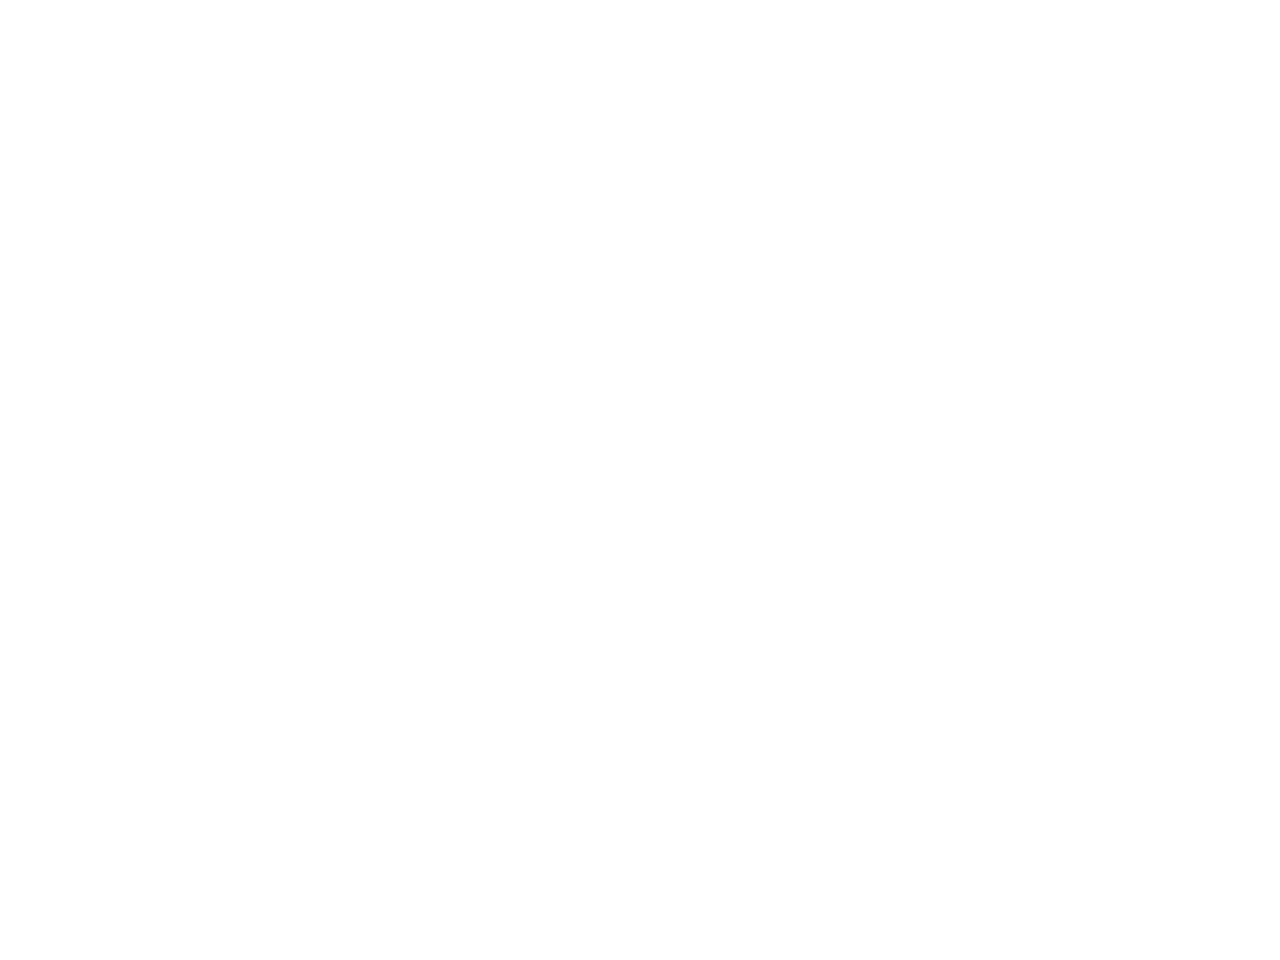

compute residual
finished computing values


[]

In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(random_omegas, norm_random_omegas,  '-', label = "norm")
ax.set_xlabel("omega")
ax.set_ylabel("norm of solution")
ax.set_title("norm of solution in reduced space")
plt.semilogy()

fig, ax = plt.subplots()         
ax.plot(random_omegas, residual_random_omegas , '-')
residual = space1.computeValues(space1.getSnapshots(), norm = False)
ax.plot(space1.getSnapshots(), residual, 'r.', label = "snapshot parameters")
ax.legend()
ax.set_xlabel("omega")
ax.set_ylabel('residual of solution')
ax.set_title("residual in reduced space")
plt.semilogy()

Let $M \in \mathbb{R}^{N\times N}$ and $K \in \mathbb{R}^{N\times N}$ be the corresponding matrices for problem $(1)$ in the reduced space. We choose our `space` to be real valued, so the Eigenvalues $\lambda $ of
\begin{equation}
    \lambda Mx = -Kx.
\end{equation}
are real valued and positive. Therefore we can easily compute them und compare $\sqrt{\lambda}$ to the positions of the peaks visible in the plot of the norm. We see that they align as expected.

<IPython.core.display.Javascript object>


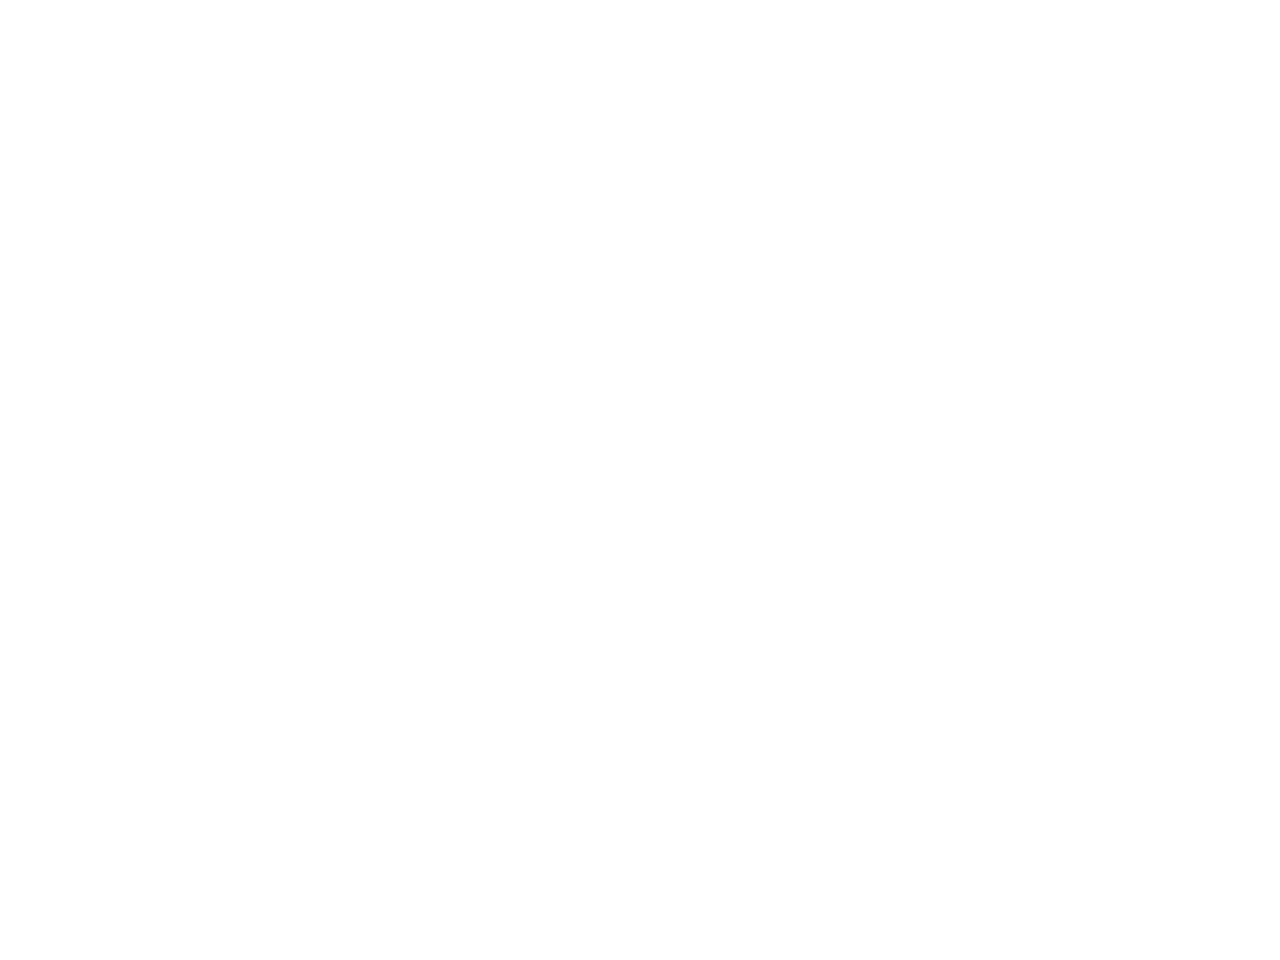

[]

In [10]:
eig = np.sqrt(scipy.linalg.eigh(space1.red[0],-space1.red[2], eigvals_only=True))
eig = eig[eig <= space1.omega_max]

fig, ax = plt.subplots()
ax.plot(random_omegas, norm_random_omegas,  '-', label = "norm")
ax.plot(eig, 1/2*np.ones(len(eig)), 'r.', label= "eigenvalues")
ax.legend()

ax.set_xlabel("omega")
ax.set_ylabel("norm of solution")
ax.set_title("norm of solution in reduced space")
plt.semilogy()


Now we define a space with Robin boundaries and plot norm and residual.

In [11]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.2))
cfes = H1(mesh, order=3, dirichlet="bottom|right", complex=True)
u,v = cfes.TnT()
x_0 = 0.6
y_0 = 0.3
rhs = 100*exp(-20*((x-x_0)**2 + (y-y_0)**2)) *v*dx

csnapshots = np.arange(1,11, 1)
cspace = ReducedBasis(cfes, [grad(u)*grad(v)*dx, -1j*u*v*ds, -u*v *dx], rhs, csnapshots)

slider_func = lambda x: cspace.draw(x, redraw=True)
cspace.draw(cspace.omega_min)

interact(slider_func, x=widgets.FloatSlider(min=cspace.omega_min, max=cspace.omega_max, step=0.05, value=cspace.omega_min))

compute Reduced Basis for snapshots  [ 1  2  3  4  5  6  7  8  9 10]
finished computing Reduced Basis
omega: 1, norm of solution: 2.7968961509500705


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2007-9-ga349a5c89', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, …

interactive(children=(FloatSlider(value=1.0, description='x', max=10.0, min=1.0, step=0.05), Output()), _dom_c…

<function __main__.<lambda>(x)>

compute residual and norm
finished computing values


<IPython.core.display.Javascript object>


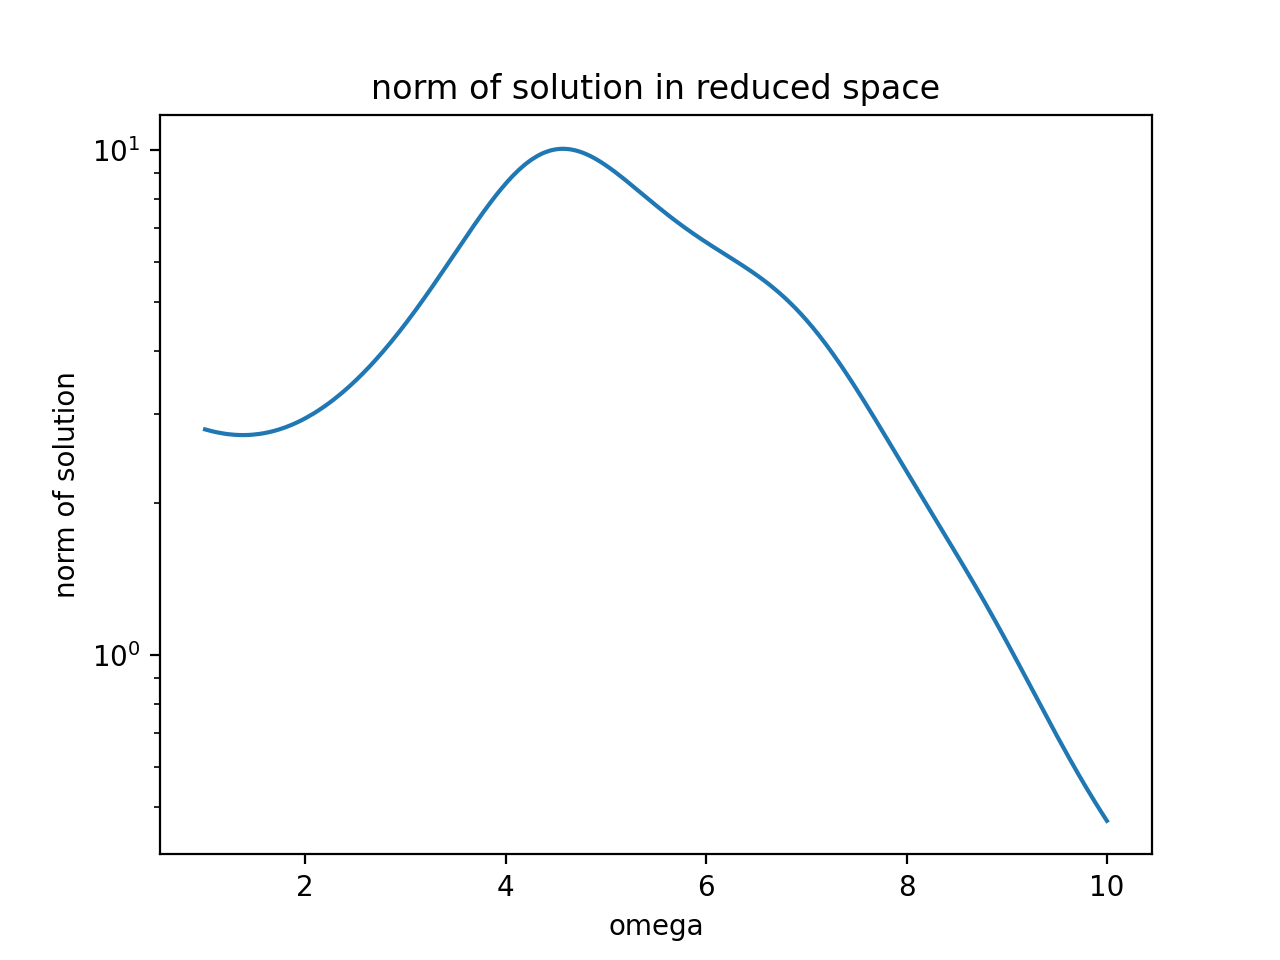

<IPython.core.display.Javascript object>


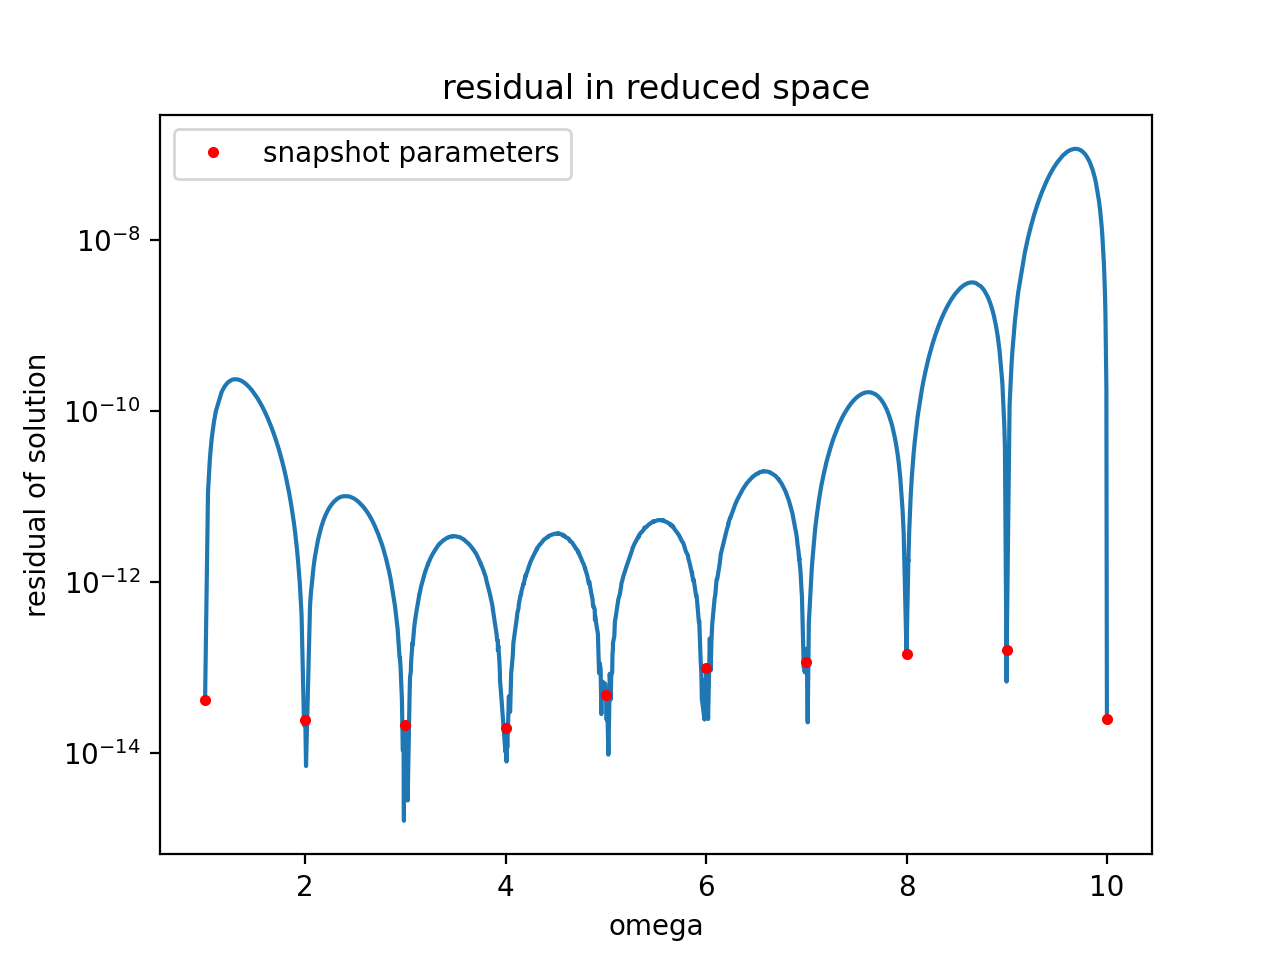

compute residual
finished computing values


[]

In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt

crandom_omegas = np.sort(np.append(np.random.uniform(cspace.omega_min, cspace.omega_max, 1000), csnapshots))

cnorm_random_omegas, cresidual_random_omegas = cspace.computeValues(crandom_omegas)

fig, ax = plt.subplots()
ax.plot(crandom_omegas, cnorm_random_omegas,  '-', label = "norm")
ax.set_xlabel("omega")
ax.set_ylabel("norm of solution")
ax.set_title("norm of solution in reduced space")
plt.semilogy()

fig, ax = plt.subplots()         
ax.plot(crandom_omegas, cresidual_random_omegas , '-')
residual = cspace.computeValues(cspace.getSnapshots(), norm = False)
ax.plot(cspace.getSnapshots(), residual, 'r.', label = "snapshot parameters")
ax.legend()
ax.set_xlabel("omega")
ax.set_ylabel('residual of solution')

ax.set_title("residual in reduced space")
plt.semilogy()